In [1]:
import numpy as np
import pandas as pd
from tqdm import tqdm_notebook
import nltk

# Study on frequencies

In [2]:
from langmodels.corpora import ngrams_example as md

In [3]:
db_name = 'movie-dialogs'

In [4]:
corpus = md.Corpus(db_name=db_name)

## Example corpora

In [5]:
m42 = md.Movie(db_name=db_name, movie_id='m42')
m170 = md.Movie(db_name=db_name, movie_id='m170')

In [6]:
for field in m42.fields:
    print("**{}**: {}".format(field, getattr(m42, field)))
print("**{}**: {}".format('size', m42.size))
m42.unigram_frequencies(m42.get_lines_text())
print("**{}**: {}".format('tokens', m42.N))
for line in m42.get_lines_text()[:2]:
    print(">", line)

**title**: casablanca
**year**: 1942
**rating**: 8.8
**votes**: 170874
**genres**: ['drama', 'romance', 'war']
**size**: 834
**tokens**: 11410
> Unoccupied France welcomes you to Casablanca.
> Thank you, Captain. It's very good to be here.


In [7]:
for field in m170.fields:
    print("**{}**: {}".format(field, getattr(m170, field)))
print("**{}**: {}".format('size', m170.size))
m170.unigram_frequencies(m170.get_lines_text())
print("**{}**: {}".format('tokens', m170.N))
for line in m170.get_lines_text()[:2]:
    print(">", line)

**title**: reservoir dogs
**year**: 1992
**rating**: 8.4
**votes**: 217185
**genres**: ['crime', 'mystery', 'thriller']
**size**: 465
**tokens**: 9289
> Toby... who the fuck is Toby? Toby... Toby... think... think... think...
> It's not about a nice girl who meets a sensitive boy. Now granted that's what "True Blue" is about, no argument about that.


## Unigram Maximum likelihood estimation

In [8]:
word = 'love'

In [9]:
print(m42.unigram[word])
print(m42.N)
print(m42.unigram[word] / m42.N)

13
11410
0.0011393514460999123


### Log probabilities

In [10]:
s = ['welcomes', 'you', 'to', 'casablanca']
p_w = np.prod([m42.p(w) for w in s])
p_w_log = np.sum([m42.p(w, log_probabilities=True) for w in s])
np.allclose([p_w], [np.exp(p_w_log)])

True

### Words order

In [11]:
s1 = ['welcomes', 'you', 'to', 'casablanca']
s2 = ['casablanca', 'you', 'to', 'welcomes']
p_w_log_1 = np.sum([m42.p(w, log_probabilities=True) for w in s1])
p_w_log_2 = np.sum([m42.p(w, log_probabilities=True) for w in s2])
np.allclose([p_w_log_1], [p_w_log_2])

True

In [12]:
np.exp(p_w_log)

3.3153929047727935e-10

## Compare corpora

In [13]:
def p(word, corpora):
    f_sharp = sum([x.unigram[word] for x in corpora])
    return f_sharp / sum([x.N for x in corpora])

In [14]:
p('you', [m42, m170])

0.039373882796270354

In [15]:
m42.p('you')

0.043382997370727434

In [16]:
np.log(m170.p('you') / p('you', [m42, m170]))

-0.13361263192682074

In [17]:
def pmi(word, corpus, all_corpora):
    return np.log(corpus.p(word) / p(word, all_corpora))

In [18]:
data = {}
corpora = [m42, m170]
words = ['woman', 'girl', 'man', 'boy', 'hello', 'yesterday']
for word in words:
    data[word] = {}
    for corpus in corpora:
        data[word]["{} ({})".format(
            corpus.movie_id, 
            corpus.title)] = round(pmi(word, 
                                       corpus, corpora), 3)
PMI = pd.DataFrame(data)

In [19]:
print(PMI.to_markdown())

|                       |   woman |   girl |    man |    boy |   hello |   yesterday |
|:----------------------|--------:|-------:|-------:|-------:|--------:|------------:|
| m42 (casablanca)      |   0.239 | -0.098 |  0.154 | -0.252 |   0.5   |      -0.098 |
| m170 (reservoir dogs) |  -0.403 |  0.108 | -0.228 |  0.242 |  -1.597 |       0.108 |


### Scatterplot

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

/Users/alfio/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [21]:
save_file = "/Users/alfio/Teaching/2019-20/inforet/lectures/thematic-studies/S1-language-models/imgs/{}"

In [22]:
data = {}
corpora = [m42, m170]
words = [x for x in m42.unigram.keys() if x in m170.unigram.keys()]
for word in words:
    data[word] = {'size': sum([c.unigram[word] for c in corpora])}
    for corpus in corpora:
        try:
            data[word]["{}".format(
                corpus.movie_id)] = round(pmi(word, 
                                           corpus, corpora), 3)
        except ZeroDivisionError:
            print(word, corpus.movie_id)
PMI = pd.DataFrame(data)

In [23]:
PMI.shape

(3, 550)

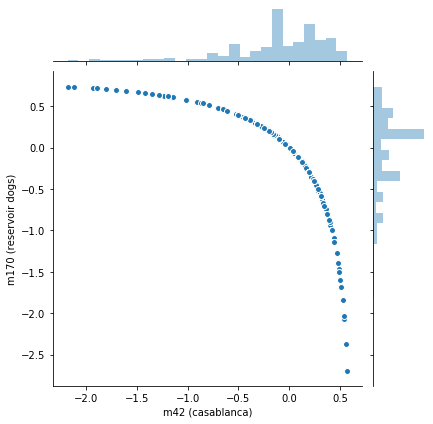

In [24]:
g = sns.jointplot(x='m42', 
              y='m170', edgecolor="w", data=PMI.T);
ax = g.ax_joint
ax.set_xlabel('m42 (casablanca)')
ax.set_ylabel('m170 (reservoir dogs)')
plt.savefig(save_file.format('unigram_joindist.png'))
plt.show()

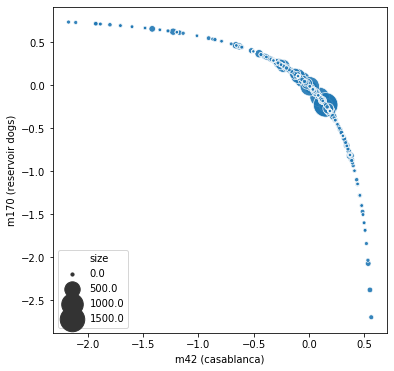

In [25]:
fig, ax = plt.subplots(figsize=(6, 6))
cmap = sns.cubehelix_palette(rot=-.6, as_cmap=True)
sns.scatterplot(ax=ax, x='m42', y='m170', alpha=0.9, 
                     data=PMI.T, size="size", 
                     palette=cmap, sizes=(10, 600));
ax.set_xlabel('m42 (casablanca)')
ax.set_ylabel('m170 (reservoir dogs)')
plt.legend(loc='lower left')
plt.savefig(save_file.format('unigram_scatter.png'))
plt.show()

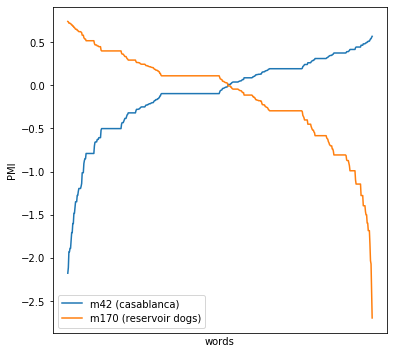

In [26]:
fig, ax = plt.subplots(figsize=(6, 6))
a = PMI.T.sort_values('m42').m42
b = PMI.T.sort_values('m42').m170
ax.get_xaxis().set_visible(True)
ax.get_xaxis().set_ticks([])
ax.plot(a, label='m42 (casablanca)')
ax.plot(b, label='m170 (reservoir dogs)')
ax.set_xlabel('words')
ax.set_ylabel('PMI')
plt.legend()
plt.savefig(save_file.format('unigram_lines.png'))
plt.show()

## 2-grams and 3-grams

In [27]:
from collections import defaultdict

In [28]:
m42.bigram_frequencies(m42.get_lines_text())
m42.trigram_frequencies(m42.get_lines_text())

In [29]:
m170.bigram_frequencies(m170.get_lines_text())
m170.trigram_frequencies(m170.get_lines_text())

In [30]:
print(m42.unigram['new'], m42.unigram['york'], 
      m42.bigram[('new', 'york')], m42.bigram[('york', 'new')])
print(m42.p('new', 'york'))
print(m42.p('york', 'new'))

6 5 5 0
0.8333333333333334
0.0


In [31]:
example = [m42.tokenize(x, remove_stopwords=False) for x in 
           m42.get_lines_text() if 'york' in x.lower()]

In [32]:
tokens = example[1]
print(tokens)
mark = ['#S'] + tokens + ['#E']
print(mark)
bigrams = list(nltk.ngrams(mark, 2))
print(bigrams)

['how', 'about', 'new', 'york']
['#S', 'how', 'about', 'new', 'york', '#E']
[('#S', 'how'), ('how', 'about'), ('about', 'new'), ('new', 'york'), ('york', '#E')]


In [33]:
tokens2 = example[0]
mark2 = ['#S'] + tokens2 + ['#E']
bigrams2 = list(nltk.ngrams(mark2, 2))
all_bigrams = bigrams + bigrams2

In [34]:
bigrams3 = [('#S', 'i'), ('i', 'was'), ('was', 'born'), 
            ('born', 'in'), ('in', 'new'), ('new', 'york'), 
            ('york', 'city'), ('city', '#E')]

In [35]:
data = defaultdict(lambda: defaultdict(lambda: 0))
for (a, b) in bigrams3:
    data[a][b] = round(m42.p(a, b), 2)
e = pd.DataFrame(data)
e.fillna(0, inplace=True)

In [36]:
print(e.T.to_markdown())

|      |    i |   was |   born |   in |   new |   york |   city |   #E |
|:-----|-----:|------:|-------:|-----:|------:|-------:|-------:|-----:|
| #S   | 0.14 |  0    |   0    |    0 |  0    |   0    |    0   |    0 |
| i    | 0    |  0.04 |   0    |    0 |  0    |   0    |    0   |    0 |
| was  | 0    |  0    |   0.02 |    0 |  0    |   0    |    0   |    0 |
| born | 0    |  0    |   0    |    1 |  0    |   0    |    0   |    0 |
| in   | 0    |  0    |   0    |    0 |  0.02 |   0    |    0   |    0 |
| new  | 0    |  0    |   0    |    0 |  0    |   0.83 |    0   |    0 |
| york | 0    |  0    |   0    |    0 |  0    |   0    |    0.2 |    0 |
| city | 0    |  0    |   0    |    0 |  0    |   0    |    0   |    0 |


In [37]:
print(bigrams2)

[('#S', 'i'), ('i', 'was'), ('was', 'born'), ('born', 'in'), ('in', 'new'), ('new', 'york'), ('york', 'city'), ('city', 'if'), ('if', 'that'), ('that', 'help'), ('help', 'you'), ('you', 'any'), ('any', '#E')]


## Evaluation

### POS tagging

In [38]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [39]:
example = list(m42.get_lines_text())[0].lower()
print(example)
print([x.pos_ for x in nlp(example)])

unoccupied france welcomes you to casablanca.
['ADJ', 'NOUN', 'VERB', 'PRON', 'ADP', 'NOUN', 'PUNCT']


### Comparison

In [40]:
training = md.Movie(db_name=db_name, 
                    movie_id='m42', k_smoothing=0.5)
test = md.Movie(db_name=db_name, movie_id='m170', 
                k_smoothing=0.5)

In [41]:
training.unigram_frequencies(training.get_lines_text(), pos=True)
training.bigram_frequencies(training.get_lines_text(), pos=True)
training.trigram_frequencies(training.get_lines_text(), pos=True)

In [42]:
testset = test.get_testset(test.get_lines_text(), pos=True)

In [43]:
p_u, _ = training.predict(testset[0], model=md.Corpus.UNIGRAM, 
                          log_probabilities=True)
pp_u = training.perplexity(testset[0], 
                           model=md.Corpus.UNIGRAM,
                           log_probabilities=True)

In [44]:
p_b, _ = training.predict(testset[0], model=md.Corpus.BIGRAM)
pp_b = training.perplexity(testset[0], model=md.Corpus.BIGRAM)

In [45]:
p_t, _ = training.predict(testset[0], model=md.Corpus.TRIGRAM)
pp_t = training.perplexity(testset[0], model=md.Corpus.TRIGRAM)

In [46]:
print('unigram', p_u, pp_u)
print('bigram', p_b, pp_b)
print('trigram', p_t, pp_t)

unigram 1656676.4840325362 0.9123618359660921
bigram 7.223429312823913e-17 7.071960391443772
trigram 5.498139259451355e-16 7.04313142581017


In [47]:
P_u, P_b, P_t = 0, 0, 0
for x in testset:
    try:
        P_u += training.perplexity(x, 
                                   model=md.Corpus.UNIGRAM,
                                   log_probabilities=True)
        P_b += training.perplexity(x, model=md.Corpus.BIGRAM,
                                  log_probabilities=True)
        P_t += training.perplexity(x, model=md.Corpus.TRIGRAM,
                                  log_probabilities=True)
    except ZeroDivisionError:
        pass
P_u, P_b, P_t = P_u / len(testset), P_b / len(testset), P_t / len(testset)

In [48]:
print('unigram', round(P_u, 3))
print('bigram', round(P_b, 3))
print('trigram', round(P_t, 3))

unigram 0.93
bigram 0.83
trigram 0.802
